# METHOD: build a classification model

# AIM: Genetic features to predict clinical benefits

! pip3 install -U scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import sys

In [4]:
import sklearn
print(sklearn.__version__)

1.4.2


# select genes based on gene expression values

In [5]:
genetic = pd.read_csv("Expression_log2_21_primaryNivo_braun_2020.csv",index_col=0)
genetic

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
gene_name,,,,,,,,,,,,,,,,,,,,,
G138701_RCCBMS-00020-T_v1_RNA_OnPrem,30.187983,22.999432,33.643965,37.130851,22.705126,22.869853,21.076515,21.271282,21.807184,33.279532,...,33.26816,30.04056,30.36292,30.98129,32.38442,28.01561,31.24379,33.81903,33.22469,31.23383
G138701_RCCBMS-00097-T_v1_RNA_OnPrem,30.483638,25.581769,28.866645,37.945043,27.797609,24.142100,21.076515,21.271282,21.807184,33.019435,...,31.53633,29.94062,30.80829,30.74475,32.09470,26.32526,32.70057,33.67262,33.10198,32.44643
G138701_RCCBMS-00141-T_v1_RNA_OnPrem,30.092851,26.933385,26.684228,36.851946,22.705126,30.406352,21.076515,21.271282,21.807184,31.033210,...,30.74474,31.95812,30.73898,30.15898,31.69473,26.33098,32.68330,33.96047,32.97135,32.20607
G138701_RCCBMS-00099-T_v1_RNA_OnPrem,30.975010,26.683128,32.521494,38.453517,26.337846,28.229357,21.076515,21.271282,26.484608,33.009203,...,31.63196,30.71732,31.09654,30.25757,31.90774,27.53819,32.64194,34.54254,33.24885,32.78278
G138701_RCCBMS-00163-T_v1_RNA_OnPrem,26.915750,22.999432,23.219176,38.931987,22.705126,22.869853,21.076515,21.271282,21.807184,31.447751,...,31.75620,30.75149,30.55896,30.17101,31.01545,21.45312,32.86620,34.24375,34.86720,32.73361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P66507-04D-Run1_S3_L001,29.718678,21.286965,33.059162,35.566022,21.357557,27.686244,20.980667,25.034267,21.018133,33.704298,...,28.60179,30.27215,31.08287,31.21266,33.18573,29.26041,31.70839,32.97611,34.23396,32.87393
P66507-07G-Run1_S17_L002,31.147910,21.286965,31.617351,37.423994,21.357557,27.720569,20.980667,20.992693,28.011280,35.638479,...,26.14211,31.31652,31.24066,31.34713,33.06662,27.08693,30.62278,35.10264,33.68084,30.73622
P66425-03B-Run1_S10_L001,30.099518,25.040893,33.891608,38.289830,21.357557,26.870362,20.980667,20.992693,21.018133,33.654328,...,32.54706,29.97152,31.22229,30.38211,31.30604,27.29504,32.44263,34.20699,32.80918,32.29759


In [6]:
cl = pd.read_csv("braun_data_clinical_data.csv",index_col=0)
dfcl = cl.loc[genetic.index,:][cl["Benefit"].isin(["CB","NCB"])].Benefit.reset_index()

/tmp/ipykernel_4026761/3273625017.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfcl = cl.loc[genetic.index,:][cl["Benefit"].isin(["CB","NCB"])].Benefit.reset_index()


In [7]:
dfmerge = pd.merge(genetic.reset_index(),cl.reset_index(),how='left', left_on="gene_name", right_on="RNA_ID")
dfmerge.shape

(133, 20561)

#selection process by cox
from lifelines import CoxPHFitter
df_cox_os, df_cox_pfs = pd.DataFrame(), pd.DataFrame()
topvar = genetic.columns.tolist()
for j,i in enumerate(topvar):
    print(j, end='\r')
    sys.stdout.flush()
    df_os1 = dfmerge[[i,'OS', 'OS_CNSR']]
    cph = CoxPHFitter()
    cph.fit(df_os1, duration_col='OS', event_col='OS_CNSR')#,show_progress=True)
    df_cox_os = pd.concat([df_cox_os,cph.summary])

    df_os2 = dfmerge[[i,'PFS', 'PFS_CNSR']]
    cph = CoxPHFitter()
    cph.fit(df_os2, duration_col='PFS', event_col='PFS_CNSR')
    df_cox_pfs = pd.concat([df_cox_pfs,cph.summary]) 

In [8]:
df_cox_os, df_cox_pfs = pd.read_csv("gene_expression_cox_pN_os.txt",index_col=0), pd.read_csv("gene_expression_cox_pN_pfs.txt",index_col=0)

In [9]:
df_cox_os[df_cox_os["p"]<0.01]
df_cox_pfs[df_cox_pfs["p"]<0.01]
selected_genes = list(set(df_cox_os[df_cox_os["p"]<0.01].index).intersection(df_cox_pfs[df_cox_pfs["p"]<0.01].index))
len(selected_genes)

64

df_cox_os.to_csv("gene_expression_cox_pN_os.txt")
df_cox_pfs.to_csv("gene_expression_cox_pN_pfs.txt")

In [10]:
dfcl

,gene_name,Benefit
0,G138701_RCCBMS-00020-T_v1_RNA_OnPrem,CB
1,G138701_RCCBMS-00097-T_v1_RNA_OnPrem,CB
2,G138701_RCCBMS-00141-T_v1_RNA_OnPrem,CB
3,G138701_RCCBMS-00099-T_v1_RNA_OnPrem,NCB
4,G138701_RCCBMS-00053-T_v1_RNA_OnPrem,CB
...,...,...
85,EA639040,NCB
86,P66507-04D-Run1_S3_L001,CB
87,P66507-07G-Run1_S17_L002,CB
88,EA639069,NCB


In [11]:
modelinput_expr = genetic.loc[dfcl["gene_name"],selected_genes]
print(modelinput_expr.shape)
modeltarget_expr = dfcl["Benefit"].replace("NCB",0).replace("CB",1).tolist()

(90, 64)


# network features input are avaiable:

In [12]:
connectivity_pos_selected = pd.read_csv("ML_input_connectivity_pN_positive.txt",index_col=0)
connectivity_neg_selected = pd.read_csv("ML_input_connectivity_pN_negative.txt",index_col=0)
edges_selected = pd.read_csv("ML_input_edges_primaryNivo.txt",index_col=0)

gsva_selected = pd.read_csv("input_ML_gsva_pN.txt",index_col=0)
entropy_selected = pd.read_csv("input_ML_entropy_pN.txt",index_col=0)

In [13]:
connec_pos_input = connectivity_pos_selected.loc[modelinput_expr.index]
connec_pos_input_improved = modelinput_expr.join(connec_pos_input,lsuffix='expr', rsuffix='conp')
connec_pos_input_improved.shape

(90, 85)

In [14]:
connec_neg_input = connectivity_neg_selected.loc[modelinput_expr.index]
connec_neg_input_improved = modelinput_expr.join(connec_neg_input,lsuffix='expr', rsuffix='conn')
connec_neg_input_improved.shape

(90, 112)

In [15]:
edges_input = edges_selected.loc[modelinput_expr.index]
edges_input_improved = modelinput_expr.join(edges_input,lsuffix='expr', rsuffix='edges')
edges_input_improved.shape

(90, 115)

In [16]:
gsva_input = gsva_selected.T.loc[modelinput_expr.index]

gsva_input.shape

(90, 2)

In [17]:
entropy_input = entropy_selected.T.loc[modelinput_expr.index]
entropy_input_improved = gsva_input.join(entropy_input,rsuffix='entropy', lsuffix='gsva')
entropy_input_improved.shape

(90, 5)

In [18]:
connec_pos_input
connec_neg_input
edges_input
entropy_input

,KEGG_PHOSPHATIDYLINOSITOL_SIGNALING_SYSTEM,KEGG_RENIN_ANGIOTENSIN_SYSTEM,KEGG_INOSITOL_PHOSPHATE_METABOLISM
gene_name,,,
G138701_RCCBMS-00020-T_v1_RNA_OnPrem,7.107668,1.979097,6.178632
G138701_RCCBMS-00097-T_v1_RNA_OnPrem,7.165451,2.308754,6.309572
G138701_RCCBMS-00141-T_v1_RNA_OnPrem,7.215053,1.573097,6.254714
G138701_RCCBMS-00099-T_v1_RNA_OnPrem,7.332763,1.987366,6.360396
G138701_RCCBMS-00053-T_v1_RNA_OnPrem,7.010232,1.576224,6.096311
...,...,...,...
EA639040,7.194554,2.313211,6.234925
P66507-04D-Run1_S3_L001,6.782024,2.316471,5.794862
P66507-07G-Run1_S17_L002,6.926409,1.581287,5.753185


# Logistic regression classification model

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report

In [20]:
from sklearn.linear_model import  LogisticRegression, SGDClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

In [21]:
dfcl["Benefit"].replace("NCB",0).replace("CB",1)
#dfcl["Benefit"]

0     1
1     1
2     1
3     0
4     1
     ..
85    0
86    1
87    1
88    0
89    0
Name: Benefit, Length: 90, dtype: int64

In [22]:
from pandas.plotting import scatter_matrix
#modelinput_expr.hist(xlabelsize=1,ylabelsize=1)

# Comparison of ML models

In [23]:
## 分割資料
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

## 報表結果、模型評估
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## modelbuilding 各模型套件
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [24]:
print(dfcl["Benefit"].count())
dfcl["Benefit"][dfcl["Benefit"]=="CB"].count()

90


44

In [25]:
# Spot Check Algorithms

for datetype,dataname in \
    zip([modelinput_expr],\
        ["expr"]):
    
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl.set_index("gene_name")["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.3,random_state=0)
    print(y_train.shape,y_test.shape)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    print(dataname)
    
    models = []
    models.append(('LR',LogisticRegression()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=1)))
    models.append(('SVM', SVC(gamma='auto')))
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
    	kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
        #使用 cv ，並用validation data 計算 validation error 判斷哪種模型比較好
    	model.fit(scaled_X_train,y_train)
    	cv_results = cross_val_score(model, scaled_X_train, y_train, cv=kfold, scoring='accuracy')
        
    	results.append(cv_results)
    	names.append(name)
    	print(model.score(scaled_X_test,y_test))
    	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        

(63,) (27,)
expr
0.6666666666666666
LR: 0.650000 (0.130089)
0.5555555555555556
KNN: 0.588462 (0.112529)
0.5185185185185185
CART: 0.476923 (0.055971)
0.5185185185185185
RF: 0.712821 (0.098593)
0.7407407407407407
SVM: 0.697436 (0.081023)


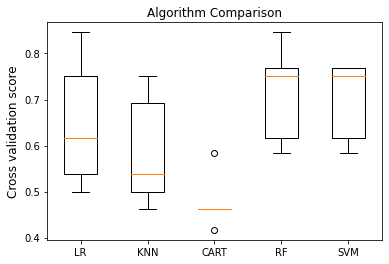

In [26]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison',fontsize=12)
plt.ylabel("Cross validation score",fontsize=12)
#plt.savefig(f"expression_ML_comparison.svg",dpi=600,bbox_inches='tight')
plt.show()

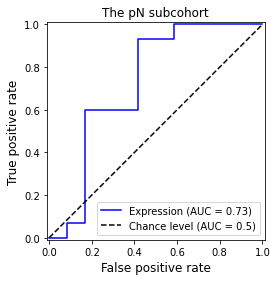

lr准确率： 0.6666666666666666
lr的其他指标：
               precision    recall  f1-score   support

          CB       0.69      0.73      0.71        15
         NCB       0.64      0.58      0.61        12

    accuracy                           0.67        27
   macro avg       0.66      0.66      0.66        27
weighted avg       0.66      0.67      0.66        27



In [27]:
X_train, X_test, y_train, y_test = train_test_split(modelinput_expr, 
                                                     dfcl["Benefit"],
                                                   test_size=0.3,random_state=0)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(scaled_X_train, y_train)
lr_y_predict = lr.predict(scaled_X_test)


#fig, ax = plt.subplots() 
RocCurveDisplay.from_estimator(lr,scaled_X_test, y_test,pos_label="CB",plot_chance_level=True,name=f"Expression",c="blue")
plt.title('The pN subcohort',fontsize=12)
plt.ylabel("True positive rate",fontsize=12)
plt.xlabel("False positive rate",fontsize=12)
#plt.savefig(f"expression_AUC.svg",dpi=600,bbox_inches='tight')
plt.show()

print("lr准确率：", lr.score(scaled_X_test, y_test))
print("lr的其他指标：\n", classification_report(y_test, lr_y_predict, target_names=["CB", "NCB"],zero_division=0.0))
### ROC plot


(63,) (27,)
edges
0.6296296296296297
LR: 0.587179 (0.028263)
0.5555555555555556
KNN: 0.619231 (0.026770)
0.7037037037037037
CART: 0.585897 (0.066072)
0.7037037037037037
RF: 0.682051 (0.111369)
0.7037037037037037
SVM: 0.633333 (0.072342)


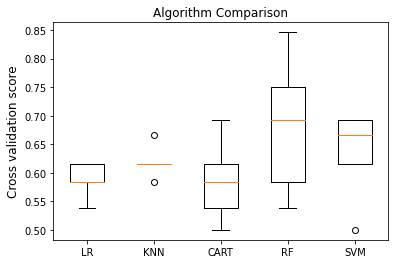

In [28]:
# Spot Check Algorithms

for datetype,dataname in \
    zip([edges_input],\
        ["edges"]):
    
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl.set_index("gene_name")["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.3,random_state=0)
    print(y_train.shape,y_test.shape)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    print(dataname)
    
    models = []
    models.append(('LR',LogisticRegression()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=1)))
    models.append(('SVM', SVC(gamma='auto')))
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
    	kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
        #使用 cv ，並用validation data 計算 validation error 判斷哪種模型比較好
    	model.fit(scaled_X_train,y_train)
    	cv_results = cross_val_score(model, scaled_X_train, y_train, cv=kfold, scoring='accuracy')
        
    	results.append(cv_results)
    	names.append(name)
    	print(model.score(scaled_X_test,y_test))
    	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison',fontsize=12)
plt.ylabel("Cross validation score",fontsize=12)
#plt.savefig(f"expression_ML_comparison.svg",dpi=600,bbox_inches='tight')
plt.show()

(63,) (27,)
connec
0.6296296296296297
LR: 0.570513 (0.082291)
0.6296296296296297
KNN: 0.585897 (0.121057)
0.5555555555555556
CART: 0.521795 (0.098610)
0.7407407407407407
RF: 0.414103 (0.152645)
0.7037037037037037
SVM: 0.700000 (0.126228)


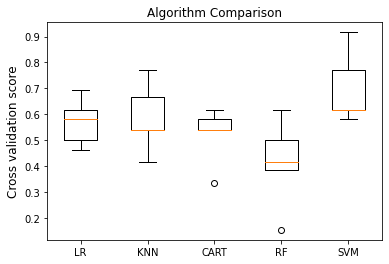

In [29]:
# Spot Check Algorithms

for datetype,dataname in \
    zip([connec_neg_input],\
        ["connec"]):
    
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl.set_index("gene_name")["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.3,random_state=0)
    print(y_train.shape,y_test.shape)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    print(dataname)
    
    models = []
    models.append(('LR',LogisticRegression()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=1)))
    models.append(('SVM', SVC(gamma='auto')))
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
    	kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
        #使用 cv ，並用validation data 計算 validation error 判斷哪種模型比較好
    	model.fit(scaled_X_train,y_train)
    	cv_results = cross_val_score(model, scaled_X_train, y_train, cv=kfold, scoring='accuracy')
        
    	results.append(cv_results)
    	names.append(name)
    	print(model.score(scaled_X_test,y_test))
    	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison',fontsize=12)
plt.ylabel("Cross validation score",fontsize=12)
#plt.savefig(f"expression_ML_comparison.svg",dpi=600,bbox_inches='tight')
plt.show()

(63,) (27,)
entropy
0.6296296296296297
LR: 0.444872 (0.079611)
0.4074074074074074
KNN: 0.585897 (0.095390)
0.5925925925925926
CART: 0.541026 (0.185459)
0.6666666666666666
RF: 0.589744 (0.115811)
0.48148148148148145
SVM: 0.556410 (0.087085)


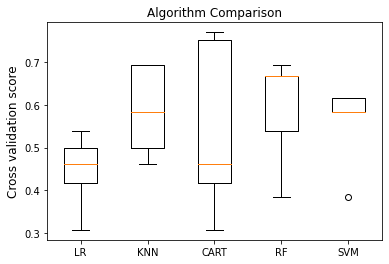

In [30]:
# Spot Check Algorithms

for datetype,dataname in \
    zip([gsva_input],\
        ["entropy"]):
    
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl.set_index("gene_name")["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.3,random_state=0)
    print(y_train.shape,y_test.shape)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    print(dataname)
    
    models = []
    models.append(('LR',LogisticRegression()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=1)))
    models.append(('SVM', SVC(gamma='auto')))
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
    	kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
        #使用 cv ，並用validation data 計算 validation error 判斷哪種模型比較好
    	model.fit(scaled_X_train,y_train)
    	cv_results = cross_val_score(model, scaled_X_train, y_train, cv=kfold, scoring='accuracy')
        
    	results.append(cv_results)
    	names.append(name)
    	print(model.score(scaled_X_test,y_test))
    	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison',fontsize=12)
plt.ylabel("Cross validation score",fontsize=12)
#plt.savefig(f"expression_ML_comparison.svg",dpi=600,bbox_inches='tight')
plt.show()

# performance of ML

## LR

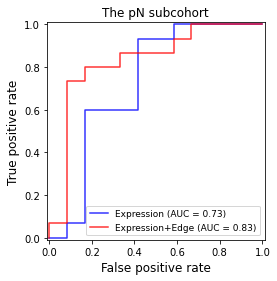

In [31]:
#for  i in ["connec_pos_input","connec_neg_input","edges_input","entropy_input"]:

dic_co = {"Expression":"blue","Edge":"purple","Expression+Edge":"red"}

fig, ax = plt.subplots() 

for datetype,dataname in \
    zip([modelinput_expr,edges_input_improved],\
        ["Expression","Expression+Edge"]):
            
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"],
                                                   test_size=0.3,random_state=0)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    # LR
    lr = LogisticRegression().fit(scaled_X_train, y_train)
    lr =RocCurveDisplay.from_estimator(lr,  scaled_X_test, y_test, name=f"{dataname}",pos_label="CB", ax=ax, alpha=0.8,color=dic_co[dataname])

plt.legend(fontsize=9) 
plt.title('The pN subcohort',fontsize=12)
plt.ylabel("True positive rate",fontsize=12)
plt.xlabel("False positive rate",fontsize=12)
#splt.savefig(f"expression+edges_AUC_lr.svg",dpi=600,bbox_inches='tight')
plt.show()

In [32]:
#for  i in ["connec_pos_input","connec_neg_input","edges_input","entropy_input"]:
from sklearn.metrics import roc_auc_score    
#fig, ax = plt.subplots() 
dic_auc = {}
for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["Expression","Positive-connectivity","Negative-connectivity","Edge","Expression+Positive-connectivity",
         "Expression+Negative-connectivity","Expression+Edge","GSVA","Entropy","GSVA+Entropy"]):
            
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"],
                                                   test_size=0.3,random_state=0)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    lr = LogisticRegression().fit(scaled_X_train, y_train)
    # Get predicted probabilities for the positive class
    y_probs = lr.predict_proba(scaled_X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_probs)

    dic_auc[dataname] = auc
    print(dataname, auc)

    

Expression 0.7277777777777779
Positive-connectivity 0.7333333333333334
Negative-connectivity 0.7055555555555556
Edge 0.75
Expression+Positive-connectivity 0.7555555555555555
Expression+Negative-connectivity 0.7388888888888889
Expression+Edge 0.8277777777777778
GSVA 0.6888888888888889
Entropy 0.7277777777777777
GSVA+Entropy 0.7166666666666667


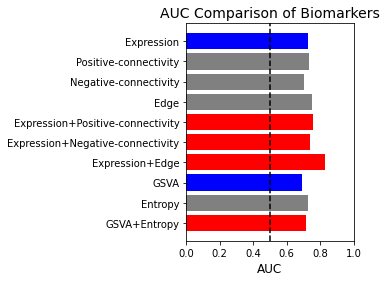

In [33]:
#colors =['#00BFC4' if i == 0 else 'gray' for i in range(len(models))]
colors = ["blue","grey","grey","grey","red","red","red","blue","grey","red"]

dfauc = pd.DataFrame.from_dict(dic_auc, orient='index')


dfauc.columns = ["AUC"]
plt.figure(figsize=(3, 4))
bars = plt.barh(dfauc.index, dfauc["AUC"],color=colors)

plt.axvline(0.5, color='black', linestyle='--')

plt.xlim(0, 1)  # Set x-axis limits as per the data
plt.gca().invert_yaxis()
# Add AUC title at the top
plt.xlabel('AUC', fontsize=12)
plt.title('AUC Comparison of Biomarkers', fontsize=14)
#plt.savefig(f"all_markers_AUC_lr.svg",dpi=600,bbox_inches='tight')
plt.show()

In [1]:
# LOOCV

In [42]:
from sklearn.metrics import roc_auc_score, make_scorer

Expression
Cross-validated AUC scores on the training set:  0.6284584980237155
Positive-connectivity
Cross-validated AUC scores on the training set:  0.7613636363636362
Negative-connectivity
Cross-validated AUC scores on the training set:  0.6620553359683794
Edge
Cross-validated AUC scores on the training set:  0.6808300395256917
Expression+Positive-connectivity
Cross-validated AUC scores on the training set:  0.6249999999999999
Expression+Negative-connectivity
Cross-validated AUC scores on the training set:  0.6546442687747035
Expression+Edge
Cross-validated AUC scores on the training set:  0.692193675889328
GSVA
Cross-validated AUC scores on the training set:  0.5118577075098815
Entropy
Cross-validated AUC scores on the training set:  0.6057312252964425
GSVA+Entropy
Cross-validated AUC scores on the training set:  0.5741106719367589


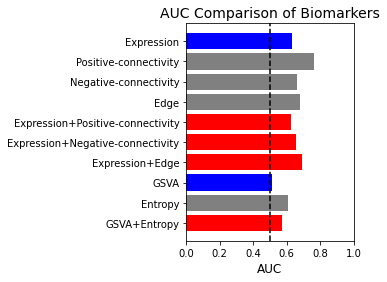

In [41]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score    
#fig, ax = plt.subplots() 
dic_auc = {}
for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["Expression","Positive-connectivity","Negative-connectivity","Edge","Expression+Positive-connectivity",
         "Expression+Negative-connectivity","Expression+Edge","GSVA","Entropy","GSVA+Entropy"]):


    """
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.1,random_state=0)
                                                """
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(datetype)
    
    lr = LogisticRegression()


    # Initialize Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    X, y = scaled_X, dfcl["Benefit"].replace("NCB",0).replace("CB",1)
    # Lists to store true labels and predicted probabilities
    y_true = []
    y_pred_prob = []
    
    # Perform LOO-CV
    for train_index, test_index in loo.split(X):
        # Split data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the model on the training data
        lr.fit(X_train, y_train)
        
        # Get the predicted probability for the test set
        y_prob = lr.predict_proba(X_test)[:, 1]  # Probability for the positive class
        #print(y_prob, y_test )
        # Store the results
        y_true.append(y_test.tolist()[0])
        y_pred_prob.append(y_prob[0])
             
    # Calculate AUC
    auc_scores = roc_auc_score(y_true, y_pred_prob)

             
    results.append(auc_scores)
    names.append(name)


    print(dataname)
    print("Cross-validated AUC scores on the training set: ", auc_scores)
    #print("Mean cross-validated AUC score: ", auc_scores.mean())
        
    dic_auc[dataname] = auc_scores
    

#colors =['#00BFC4' if i == 0 else 'gray' for i in range(len(models))]
colors = ["blue","grey","grey","grey","red","red","red","blue","grey","red"]

dfauc = pd.DataFrame.from_dict(dic_auc, orient='index')


dfauc.columns = ["AUC"]
plt.figure(figsize=(3, 4))
bars = plt.barh(dfauc.index, dfauc["AUC"],color=colors)

plt.axvline(0.5, color='black', linestyle='--')

plt.xlim(0, 1)  # Set x-axis limits as per the data
plt.gca().invert_yaxis()
# Add AUC title at the top
plt.xlabel('AUC', fontsize=12)
plt.title('AUC Comparison of Biomarkers', fontsize=14)
#plt.savefig(f"all_markers_loocv_AUC_lr.svg",dpi=600,bbox_inches='tight')
plt.show()

# RF model

In [35]:
#for  i in ["connec_pos_input","connec_neg_input","edges_input","entropy_input"]:
from sklearn.metrics import roc_auc_score    
#fig, ax = plt.subplots() 
dic_auc = {}
for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["Expression","Positive-connectivity","Negative-connectivity","Edge","Expression+Positive-connectivity",
         "Expression+Negative-connectivity","Expression+Edge","GSVA","Entropy","GSVA+Entropy"]):
            
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"],
                                                   test_size=0.3,random_state=0)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    rf =  RandomForestClassifier(n_estimators=100, random_state=1).fit(scaled_X_train, y_train)
    # Get predicted probabilities for the positive class
    y_probs = rf.predict_proba(scaled_X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_probs)

    dic_auc[dataname] = auc
    print(dataname, auc)

    

Expression 0.6833333333333333
Positive-connectivity 0.6972222222222222
Negative-connectivity 0.7222222222222222
Edge 0.7361111111111112
Expression+Positive-connectivity 0.7111111111111111
Expression+Negative-connectivity 0.7861111111111111
Expression+Edge 0.8194444444444444
GSVA 0.6416666666666666
Entropy 0.5527777777777778
GSVA+Entropy 0.5805555555555555


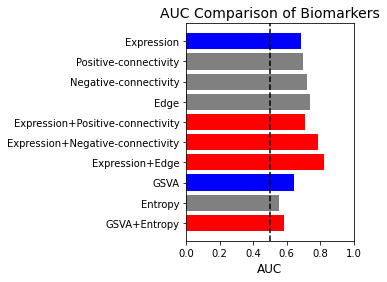

In [36]:
#colors =['#00BFC4' if i == 0 else 'gray' for i in range(len(models))]
colors = ["blue","grey","grey","grey","red","red","red","blue","grey","red"]

dfauc = pd.DataFrame.from_dict(dic_auc, orient='index')


dfauc.columns = ["AUC"]
plt.figure(figsize=(3, 4))
bars = plt.barh(dfauc.index, dfauc["AUC"],color=colors)

plt.axvline(0.5, color='black', linestyle='--')

plt.xlim(0, 1)  # Set x-axis limits as per the data
plt.gca().invert_yaxis()
# Add AUC title at the top
plt.xlabel('AUC', fontsize=12)
plt.title('AUC Comparison of Biomarkers', fontsize=14)
#plt.savefig(f"all_markers_AUC_rf.svg",dpi=600,bbox_inches='tight')
plt.show()

In [2]:
## LOOCV

Expression
Cross-validated AUC scores on the training set:  0.6803359683794465
Positive-connectivity
Cross-validated AUC scores on the training set:  0.6800889328063241
Negative-connectivity
Cross-validated AUC scores on the training set:  0.6148715415019763
Edge
Cross-validated AUC scores on the training set:  0.7621047430830039
Expression+Positive-connectivity
Cross-validated AUC scores on the training set:  0.6865118577075098
Expression+Negative-connectivity
Cross-validated AUC scores on the training set:  0.6771245059288538
Expression+Edge
Cross-validated AUC scores on the training set:  0.7544466403162055
GSVA
Cross-validated AUC scores on the training set:  0.5637351778656126
Entropy
Cross-validated AUC scores on the training set:  0.46936758893280633
GSVA+Entropy
Cross-validated AUC scores on the training set:  0.4851778656126482


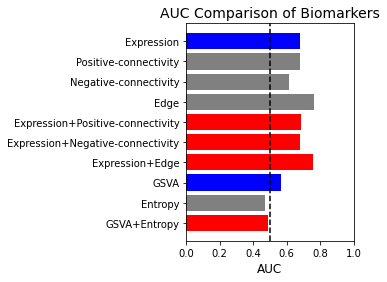

In [37]:

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score    
#fig, ax = plt.subplots() 
dic_auc = {}
for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["Expression","Positive-connectivity","Negative-connectivity","Edge","Expression+Positive-connectivity",
         "Expression+Negative-connectivity","Expression+Edge","GSVA","Entropy","GSVA+Entropy"]):


    """
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.1,random_state=0)
                                                """
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(datetype)
    
    rf =  RandomForestClassifier(n_estimators=100, random_state=1)


    # Initialize Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    X, y = scaled_X, dfcl["Benefit"].replace("NCB",0).replace("CB",1)
    # Lists to store true labels and predicted probabilities
    y_true = []
    y_pred_prob = []
    
    # Perform LOO-CV
    for train_index, test_index in loo.split(X):
        # Split data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the model on the training data
        rf.fit(X_train, y_train)
        
        # Get the predicted probability for the test set
        y_prob = rf.predict_proba(X_test)[:, 1]  # Probability for the positive class
        #print(y_prob, y_test )
        # Store the results
        y_true.append(y_test.tolist()[0])
        y_pred_prob.append(y_prob[0])
             
    # Calculate AUC
    auc_scores = roc_auc_score(y_true, y_pred_prob)

             
    results.append(auc_scores)
    names.append(name)


    print(dataname)
    print("Cross-validated AUC scores on the training set: ", auc_scores)
    #print("Mean cross-validated AUC score: ", auc_scores.mean())
        
    dic_auc[dataname] = auc_scores
    

#colors =['#00BFC4' if i == 0 else 'gray' for i in range(len(models))]
colors = ["blue","grey","grey","grey","red","red","red","blue","grey","red"]

dfauc = pd.DataFrame.from_dict(dic_auc, orient='index')


dfauc.columns = ["AUC"]
plt.figure(figsize=(3, 4))
bars = plt.barh(dfauc.index, dfauc["AUC"],color=colors)

plt.axvline(0.5, color='black', linestyle='--')

plt.xlim(0, 1)  # Set x-axis limits as per the data
plt.gca().invert_yaxis()
# Add AUC title at the top
plt.xlabel('AUC', fontsize=12)
plt.title('AUC Comparison of Biomarkers', fontsize=14)
#plt.savefig(f"all_markers_loocv_AUC_rf.svg",dpi=600,bbox_inches='tight')
plt.show()

# SVC model

In [60]:
#for  i in ["connec_pos_input","connec_neg_input","edges_input","entropy_input"]:
from sklearn.metrics import roc_auc_score    
#fig, ax = plt.subplots() 
dic_auc = {}
for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["Expression","Positive-connectivity","Negative-connectivity","Edge","Expression+Positive-connectivity",
         "Expression+Negative-connectivity","Expression+Edge","GSVA","Entropy","GSVA+Entropy"]):
            
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"],
                                                   test_size=0.3,random_state=0)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    svc = SVC(gamma='auto', probability=True).fit(scaled_X_train, y_train)
    # Get predicted probabilities for the positive class
    y_probs = svc.predict_proba(scaled_X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_probs)

    dic_auc[dataname] = auc
    print(dataname, auc)

    

Expression 0.7777777777777778
Positive-connectivity 0.7444444444444445
Negative-connectivity 0.6833333333333333
Edge 0.7555555555555555
Expression+Positive-connectivity 0.7444444444444445
Expression+Negative-connectivity 0.8
Expression+Edge 0.7888888888888889
GSVA 0.4833333333333334
Entropy 0.6499999999999999
GSVA+Entropy 0.5555555555555556


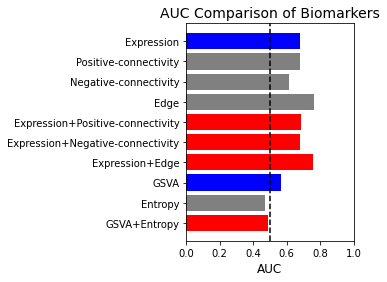

In [38]:
#colors =['#00BFC4' if i == 0 else 'gray' for i in range(len(models))]
colors = ["blue","grey","grey","grey","red","red","red","blue","grey","red"]

dfauc = pd.DataFrame.from_dict(dic_auc, orient='index')


dfauc.columns = ["AUC"]
plt.figure(figsize=(3, 4))
bars = plt.barh(dfauc.index, dfauc["AUC"],color=colors)

plt.axvline(0.5, color='black', linestyle='--')

plt.xlim(0, 1)  # Set x-axis limits as per the data
plt.gca().invert_yaxis()
# Add AUC title at the top
plt.xlabel('AUC', fontsize=12)
plt.title('AUC Comparison of Biomarkers', fontsize=14)
#plt.savefig(f"all_markers_AUC.svg",dpi=600,bbox_inches='tight')
plt.show()

# k-fold

In [ ]:
#for  i in ["connec_pos_input","connec_neg_input","edges_input","entropy_input"]:
from sklearn.metrics import roc_auc_score    
#fig, ax = plt.subplots() 
dic_auc = {}
for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["Expression","Positive-connectivity","Negative-connectivity","Edge","Expression+Positive-connectivity",
         "Expression+Negative-connectivity","Expression+Edge","GSVA","Entropy","GSVA+Entropy"]):


    """
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.1,random_state=0)
                                                """
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(datetype)
    
    svc = SVC(gamma='auto', probability=True)
    # Get predicted probabilities for the positive class
             
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    #使用 cv ，並用validation data 計算 validation error 判斷哪種模型比較好

    auc_scores = cross_val_score(svc, scaled_X,  dfcl["Benefit"].replace("NCB",0).replace("CB",1), cv=kfold, scoring=make_scorer(roc_auc_score))
    
    results.append(auc_scores)
    names.append(name)


    print(dataname)
    print("Cross-validated AUC scores on the training set: ", auc_scores)
    print("Mean cross-validated AUC score: ", auc_scores.mean())
             
    dic_auc[dataname] = auc_scores.mean()
    

#colors =['#00BFC4' if i == 0 else 'gray' for i in range(len(models))]
colors = ["blue","grey","grey","grey","red","red","red","blue","grey","red"]

dfauc = pd.DataFrame.from_dict(dic_auc, orient='index')


dfauc.columns = ["AUC"]
plt.figure(figsize=(3, 4))
bars = plt.barh(dfauc.index, dfauc["AUC"],color=colors)

plt.axvline(0.5, color='black', linestyle='--')

plt.xlim(0, 1)  # Set x-axis limits as per the data
plt.gca().invert_yaxis()
# Add AUC title at the top
plt.xlabel('AUC', fontsize=12)
plt.title('AUC Comparison of Biomarkers', fontsize=14)
#plt.savefig(f"all_markers_cv_AUC_svc.svg",dpi=600,bbox_inches='tight')
plt.show()

# lOOCV

Expression
Cross-validated AUC scores on the training set:  0.5590415019762847
Positive-connectivity
Cross-validated AUC scores on the training set:  0.6440217391304347
Negative-connectivity
Cross-validated AUC scores on the training set:  0.5748517786561265
Edge
Cross-validated AUC scores on the training set:  0.6254940711462451
Expression+Positive-connectivity
Cross-validated AUC scores on the training set:  0.5365612648221343
Expression+Negative-connectivity
Cross-validated AUC scores on the training set:  0.5271739130434782
Expression+Edge
Cross-validated AUC scores on the training set:  0.6274703557312253
GSVA
Cross-validated AUC scores on the training set:  0.3176877470355731
Entropy
Cross-validated AUC scores on the training set:  0.5429841897233202
GSVA+Entropy
Cross-validated AUC scores on the training set:  0.48246047430830036


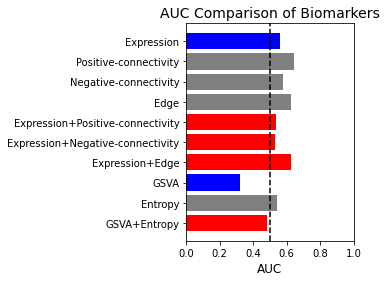

In [40]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score    
#fig, ax = plt.subplots() 
dic_auc = {}
for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["Expression","Positive-connectivity","Negative-connectivity","Edge","Expression+Positive-connectivity",
         "Expression+Negative-connectivity","Expression+Edge","GSVA","Entropy","GSVA+Entropy"]):


    """
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.1,random_state=0)
                                                """
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(datetype)
    
    svc = SVC(kernel='linear', probability=True)


    # Initialize Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    X, y = scaled_X, dfcl["Benefit"].replace("NCB",0).replace("CB",1)
    # Lists to store true labels and predicted probabilities
    y_true = []
    y_pred_prob = []
    
    # Perform LOO-CV
    for train_index, test_index in loo.split(X):
        # Split data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the model on the training data
        svc.fit(X_train, y_train)
        
        # Get the predicted probability for the test set
        y_prob = svc.predict_proba(X_test)[:, 1]  # Probability for the positive class
        #print(y_prob, y_test )
        # Store the results
        y_true.append(y_test.tolist()[0])
        y_pred_prob.append(y_prob[0])
             
    # Calculate AUC
    auc_scores = roc_auc_score(y_true, y_pred_prob)

             
    results.append(auc_scores)
    names.append(name)


    print(dataname)
    print("Cross-validated AUC scores on the training set: ", auc_scores)
    #print("Mean cross-validated AUC score: ", auc_scores.mean())
        
    dic_auc[dataname] = auc_scores
    

#colors =['#00BFC4' if i == 0 else 'gray' for i in range(len(models))]
colors = ["blue","grey","grey","grey","red","red","red","blue","grey","red"]

dfauc = pd.DataFrame.from_dict(dic_auc, orient='index')


dfauc.columns = ["AUC"]
plt.figure(figsize=(3, 4))
bars = plt.barh(dfauc.index, dfauc["AUC"],color=colors)

plt.axvline(0.5, color='black', linestyle='--')

plt.xlim(0, 1)  # Set x-axis limits as per the data
plt.gca().invert_yaxis()
# Add AUC title at the top
plt.xlabel('AUC', fontsize=12)
plt.title('AUC Comparison of Biomarkers', fontsize=14)
#plt.savefig(f"all_markers_loocv_AUC_svc.svg",dpi=600,bbox_inches='tight')
plt.show()

# plot

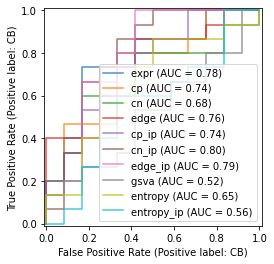

In [58]:
#for  i in ["connec_pos_input","connec_neg_input","edges_input","entropy_input"]:
    
fig, ax = plt.subplots() 

for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input,connec_neg_input,edges_input,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input,entropy_input_improved],\
        ["expr","cp","cn","edge","cp_ip","cn_ip","edge_ip","gsva","entropy","entropy_ip"]):
            
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"],
                                                   test_size=0.3,random_state=0)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    svc = SVC(gamma='auto').fit(scaled_X_train, y_train)
    svc = RocCurveDisplay.from_estimator(svc,  scaled_X_test, y_test, name=f"{dataname}",pos_label="CB", ax=ax, alpha=0.8)

    

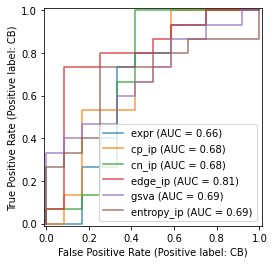

In [180]:
#for  i in ["connec_pos_input","connec_neg_input","edges_input","entropy_input"]:
    
fig, ax = plt.subplots() 

for datetype,dataname in \
    zip([modelinput_expr,connec_pos_input_improved,\
         connec_neg_input_improved,edges_input_improved,gsva_input,entropy_input_improved],\
        ["expr","cp_ip","cn_ip","edge_ip","gsva","entropy_ip"]):
            
    X_train, X_test, y_train, y_test = train_test_split(datetype, 
                                                     dfcl["Benefit"],
                                                   test_size=0.3,random_state=0)
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    clf = SVC(kernel='linear', C=1).fit(scaled_X_train, y_train)
    clf =RocCurveDisplay.from_estimator(clf,  scaled_X_test, y_test, name=f"{dataname}",pos_label="CB", ax=ax, alpha=0.8)

    

逻辑斯蒂回归准确率： 0.5925925925925926
逻辑斯蒂回归的其他指标：
               precision    recall  f1-score   support

          CB       0.53      0.83      0.65        12
         NCB       0.75      0.40      0.52        15

    accuracy                           0.59        27
   macro avg       0.64      0.62      0.58        27
weighted avg       0.65      0.59      0.58        27

随机参数估计准确率： 0.48148148148148145
随机参数估计的其他指标:
               precision    recall  f1-score   support

          CB       0.45      0.83      0.59        12
         NCB       0.60      0.20      0.30        15

    accuracy                           0.48        27
   macro avg       0.53      0.52      0.44        27
weighted avg       0.54      0.48      0.43        27



/tmp/ipykernel_837987/1183158317.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfcl["Benefit"].replace("NCB",0).replace("CB",1),


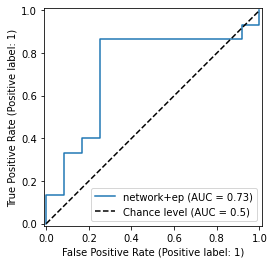

In [45]:
X_train, X_test, y_train, y_test = train_test_split(the_datainput, 
                                                     dfcl["Benefit"].replace("NCB",0).replace("CB",1),
                                                   test_size=0.3,random_state=0)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

lr = LogisticRegression() 
lr.fit(scaled_X_train, y_train)
lr_y_predict = lr.predict(scaled_X_test)

print("逻辑斯蒂回归准确率：", lr.score(scaled_X_test, y_test))
print("逻辑斯蒂回归的其他指标：\n", classification_report(y_test, lr_y_predict, target_names=["CB", "NCB"],zero_division=0.0))
### ROC plot
RocCurveDisplay.from_estimator(lr,scaled_X_test, y_test,plot_chance_level=True,name=f"network+ep")


sgdc = SGDClassifier()
sgdc.fit(scaled_X_train, y_train)
sgdc_y_predict = sgdc.predict(scaled_X_test)


print("随机参数估计准确率：", sgdc.score(scaled_X_test, y_test))
print("随机参数估计的其他指标:\n", classification_report(y_test, sgdc_y_predict, target_names=["CB", "NCB"],zero_division=0.0))